###Детекция геометрических фигур на основе контуров


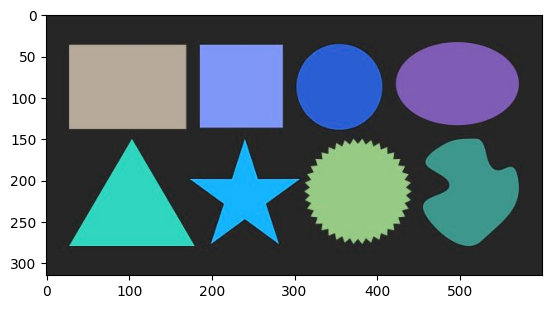

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread('image.jpg')
plt.imshow(image)

In [27]:
image.shape

(315, 600, 3)

**Шаг 1.** Предобработка изображения

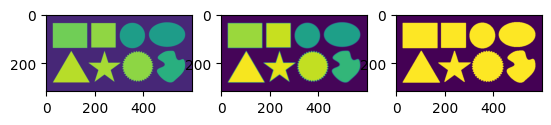

In [30]:
def preprocess_image(image):
    """
    Предобработка изображения для детекции контуров
    """
    # Конвертация в градации серого (если нужно)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Размытие для уменьшения шума
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Бинаризация (пороговая обработка)
    _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

    return gray, blurred, binary
gray, blurred, binary = preprocess_image(image)
plt.subplots(nrows=1, ncols=3)
plt.subplot(1, 3, 1)
plt.imshow(gray)
plt.subplot(1, 3, 2)
plt.imshow(blurred)
plt.subplot(1, 3, 3)
plt.imshow(binary)
plt.show()

**Шаг 2.** Поиск контуров

In [55]:
def find_contours(binary_image):
    """
    Поиск контуров на бинарном изображении
    """
    # RETR_EXTERNAL - только внешние контуры
    # RETR_LIST - все контуры без иерархии
    # CHAIN_APPROX_SIMPLE - сжатие контура (удаление избыточных точек)
    contours, hierarchy = cv2.findContours(
        binary_image,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    return contours, hierarchy
contours_, hierarchy = find_contours(binary)
len(contours_), contours_[0].shape

(8, (260, 1, 2))

In [56]:
contour = contours_[0]
ccontour = np.vstack((contour, [contour[0]]))
ccontour.shape

(261, 1, 2)

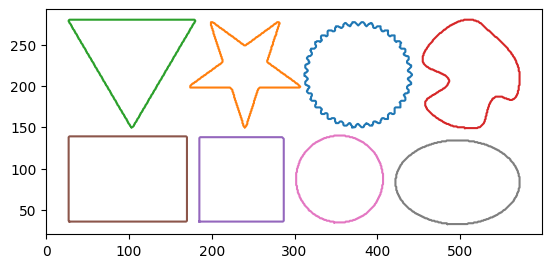

In [60]:
ax = plt.subplot()
for contour in contours_:
  contour_closed = np.vstack((contour, [contour[0]]))
  ax.plot(contour_closed.T[0][0], contour_closed.T[1][0])
ax.set_aspect('equal', adjustable='box')

**Шаг 3.** Аппроксимация контуров

In [64]:
def approximate_contours(contours, epsilon_factor=0.02):
    """
    Аппроксимация контуров для упрощения формы
    """
    approximated_contours = []

    for contour in contours:
        # Вычисление периметра контура
        perimeter = cv2.arcLength(contour, True)

        # Эпсилон - параметр точности аппроксимации
        epsilon = epsilon_factor * perimeter

        # Аппроксимация контура
        approx = cv2.approxPolyDP(contour, epsilon, True)

        approximated_contours.append(approx)

    return approximated_contours
contours = approximate_contours(contours_, 0.01)
contours[0].shape

(9, 1, 2)

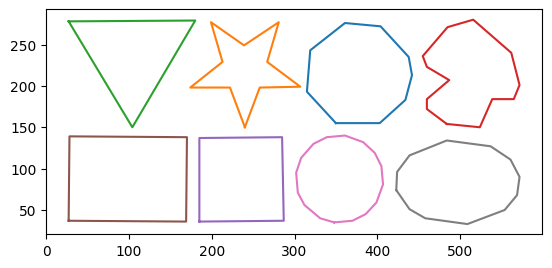

In [65]:
ax = plt.subplot()
for contour in contours:
  contour_closed = np.vstack((contour, [contour[0]]))
  ax.plot(contour_closed.T[0][0], contour_closed.T[1][0])
ax.set_aspect('equal', adjustable='box')

**Шаг 4.** Анализ геометрических свойств

In [67]:
def analyze_contour_properties(contour):
    """
    Анализ геометрических свойств контура
    """
    properties = {}

    # Площадь контура
    properties['area'] = cv2.contourArea(contour)

    # Периметр/длина контура
    properties['perimeter'] = cv2.arcLength(contour, True)

    # Ограничивающий прямоугольник
    properties['bounding_rect'] = cv2.boundingRect(contour)
    x, y, w, h = properties['bounding_rect']
    properties['aspect_ratio'] = w / h if h != 0 else 0

    # Минимальная охватывающая окружность
    properties['center'], properties['radius'] = cv2.minEnclosingCircle(contour)

    # Количество вершин аппроксимированного контура
    properties['vertices'] = len(contour)

    # Выпуклость
    properties['is_convex'] = cv2.isContourConvex(contour)

    return properties
contours_properties = {}
for i, contour in enumerate(contours):
    contours_properties[i] = analyze_contour_properties(contour)
contours_properties


{0: {'area': 11940.0,
  'perimeter': 396.8528423309326,
  'bounding_rect': (315, 155, 128, 122),
  'aspect_ratio': 1.0491803278688525,
  'center': (376.892333984375, 213.2086181640625),
  'radius': 65.10810089111328,
  'vertices': 9,
  'is_convex': True},
 1: {'area': 5874.0,
  'perimeter': 498.661865234375,
  'bounding_rect': (174, 150, 134, 128),
  'aspect_ratio': 1.046875,
  'center': (240.11123657226562, 220.15402221679688),
  'radius': 70.15420532226562,
  'vertices': 10,
  'is_convex': False},
 2: {'area': 9830.5,
  'perimeter': 452.1017150878906,
  'bounding_rect': (27, 150, 154, 130),
  'aspect_ratio': 1.1846153846153846,
  'center': (103.7710952758789, 237.0224609375),
  'radius': 87.02285766601562,
  'vertices': 3,
  'is_convex': True},
 3: {'area': 10008.0,
  'perimeter': 424.1258735656738,
  'bounding_rect': (455, 150, 118, 131),
  'aspect_ratio': 0.9007633587786259,
  'center': (510.23992919921875, 214.39938354492188),
  'radius': 65.85311889648438,
  'vertices': 13,
  'is

**Шаг 5.** Классификация фигур

In [68]:
def classify_shape(properties):
    """
    Классификация фигуры на основе свойств контура
    """
    vertices = properties['vertices']
    area = properties['area']
    perimeter = properties['perimeter']
    aspect_ratio = properties['aspect_ratio']

    # Круглость (circularity)
    if perimeter > 0:
        circularity = 4 * np.pi * area / (perimeter * perimeter)
    else:
        circularity = 0

    # Классификация по количеству вершин
    if vertices == 3:
        return "Треугольник"
    elif vertices == 4:
        # Проверяем, является ли квадратом/прямоугольником
        if 0.9 <= aspect_ratio <= 1.1:
            return "Квадрат"
        else:
            return "Прямоугольник"
    elif vertices == 5:
        return "Пятиугольник"
    elif vertices == 6:
        return "Шестиугольник"
    elif vertices > 6:
        # Для многоугольников с большим количеством вершин
        # проверяем круглость
        if circularity > 0.8:
            return "Круг/Овал"
        else:
            return f"Многоугольник ({vertices} вершин)"
    else:
        return "Неизвестная фигура"
classification = {}
for key, properties in contours_properties.items():
    classification[key] = classify_shape(properties)
classification

{0: 'Круг/Овал',
 1: 'Многоугольник (10 вершин)',
 2: 'Треугольник',
 3: 'Многоугольник (13 вершин)',
 4: 'Квадрат',
 5: 'Прямоугольник',
 6: 'Круг/Овал',
 7: 'Круг/Овал'}